In [1]:
import requests
import re
import io
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from datetime import datetime
from PyPDF2 import PdfFileReader
import logging
logger = logging.getLogger('WHO-reports-scrapper') 

logger.setLevel(logging.ERROR)

### Scraping

In [2]:
def analyze_report(url):
    '''
    Analyze a situation report url
    '''
    response = requests.get(url)
    f_obj = io.BytesIO(response.content)
    pdf = PdfFileReader(f_obj)
    page_zero = pdf.getPage(0)
    
    text  = page_zero.extractText()
    
    try:
        # use regular expression to extract date
        p_date = re.compile("Data as reported by ([a-zA-Z0-9\n\s]+).*\*", re.DOTALL)
        m_date = p_date.search(text)
        report_date_str = m_date.group(1).replace("\n","")
        report_date = datetime.strptime(report_date_str, '%d %B %Y').date()

        # use regular expression to extract global cases
        p_global = re.compile("Globally ([\s\n0-9]+)", re.DOTALL)
        m_global = p_global.search(text)
        global_cases_str = m_global.group(1).replace("\n","").strip()
        global_cases = int(global_cases_str)

        return {"date":report_date, "global_cases": global_cases}
    except AttributeError as e:
        logger.warning(f'Unable to extract from "{url}" : {e}\nSkip processing.')
        return None


In [3]:
def get_reports_urls(home_url):
    '''
    Extract situation reports URL from WHO's page
    '''
    urls = []
    response = requests.get(home_url)
    soup = BeautifulSoup(response.content, 'lxml')
    tags = soup.find_all('a')
    for tag in tags:
        if len(tag.contents)>0:
            content = str(tag.contents[0])
            if "Situation report - " in content:
                urls.append(urljoin(home_url ,  tag.get('href')))
    return urls


In [4]:
def get_WHO_stats():
    reports_home_url = 'https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports/'
    reports_urls = get_reports_urls(reports_home_url)
    stats = []
    for url in reports_urls:
        stat = analyze_report(url)
        if stat is not None:
            stats.append(stat)
    return stats

In [5]:
stats = get_WHO_stats()

### Pandas and friends

In [6]:
import pandas as pd
import seaborn as sns

In [7]:
df = pd.DataFrame(stats)

In [8]:
df.sort_values(by=['date'], inplace=True)

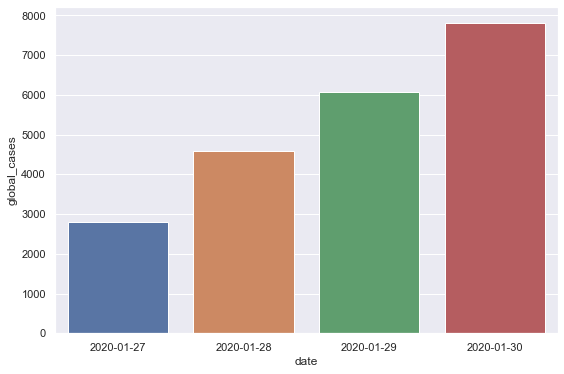

In [146]:
sns.set(rc={'figure.figsize':(9,6)})

bar_chart = sns.barplot(x='date', y='global_cases', data=df)


In [147]:
bar_chart_fig = bar_chart.get_figure()


In [11]:
# export to csv and png files
df.to_csv('data/who-global-cases.csv', index=False)
bar_chart_fig.savefig('images/who-global-cases.png')